# JumpStart: Natural  Language Processing

**Objective:** A general introduction to basic NLP methods to serve as a foundation for further self study and additional NLP curriculums. This notebook intends to serve as a basis for various techniques such as text processing, information retrieval, and classifying text.

- The Reddit dataset we will use today comes from Google BigQuery. You can find it [here](https://bigquery.cloud.google.com/table/fh-bigquery:reddit_posts.2018_05?pli=1).
 - The data is public but you need to have an active account on Google Clound Platform first in order to access it.
- The original data was huge so we sampled it from the top 10 subreddit.

- We will also learn the following NLP packages in Python along the way

 - [NLTK](http://www.nltk.org/) - a very popular package for doing NLP in Python

 - [Textblob](https://textblob.readthedocs.io/en/dev/) - similar to NLTK but provides a higher level API for easy accessing.

 - [WordCloud](https://github.com/amueller/word_cloud) - how to run wordcloud in Python

## Prerequisite

- Open your **Terminal/Anaconda Prompt**, cd to the lecture code folder and run the following command:
 - `pip install -r requirements.txt`

- After installing all the required packages, run the following command:
 - `python -m textblob.download_corpora`
 
- Restart this jupyter notebook.

In [19]:
import nltk

# Uncomment the following line the first time you run the code
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Adrian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Adrian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Adrian\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

## Load Dataset

In [3]:
import pandas as pd
df = pd.read_csv('https://s3.amazonaws.com/nycdsabt01/reddit_top10.csv')

- It is always a good idea to check the shape of the dataframe and column types before you run any type of operation.

In [5]:
df.shape

(737339, 11)

In [6]:
df.dtypes

created_utc      int64
subreddit       object
author          object
domain          object
url             object
num_comments     int64
score            int64
ups              int64
downs            int64
title           object
selftext        object
dtype: object

- When you first readin a dataset, I would recommend using `df.sample()` rather than `df.head()` because sometimes the first couple rows are fine, however, there might be missing values or mixed types in the column so it is better if you can get a big picture of the whole dataset.

In [7]:
df.sample(10)

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,selftext
160433,1526135230,FortNiteBR,SpringBonnie21,v.redd.it,https://v.redd.it/ql07decqpfx01,3,2,2,0,360° One Pump Game Winner,NaN
666268,1526879231,AskReddit,iMatiic,self.AskReddit,https://www.reddit.com/r/AskReddit/comments/8k...,27,9,9,0,What's your sleep ritual?,NaN
502841,1525669663,AskReddit,Reebs17,self.AskReddit,https://www.reddit.com/r/AskReddit/comments/8h...,23,11,11,0,Your SO confides in you that he/she committed ...,NaN
469228,1527312044,Ice_Poseidon,cameheretohelpsam,self.Ice_Poseidon,https://www.reddit.com/r/Ice_Poseidon/comments...,0,3,3,0,CASSANDRA IS ALIVE AND ON THE RV ALL ABOARD TH...,NaN
503112,1525677506,AskReddit,tjsthoughts,self.AskReddit,https://www.reddit.com/r/AskReddit/comments/8h...,35,3,3,0,[serious] what do you think happens when you die?,NaN
288358,1526495968,Showerthoughts,Puffessor,self.Showerthoughts,https://www.reddit.com/r/Showerthoughts/commen...,5,10,10,0,Texting at the urinal looks like you're taking...,NaN
475189,1527299046,RocketLeagueExchange,HolyXVI,self.RocketLeagueExchange,https://www.reddit.com/r/RocketLeagueExchange/...,2,1,1,0,[Xbox] [H] Uncommon Black OEM’s &amp; 4 PCC/NC...,NaN
57085,1525576412,Ice_Poseidon,[deleted],i.redd.it,https://i.redd.it/bin4j4tbk5w01.png,0,4,4,0,Chu say?,[deleted]
475469,1527358377,RocketLeagueExchange,NP_Hydro,self.RocketLeagueExchange,https://www.reddit.com/r/RocketLeagueExchange/...,0,3,3,0,[PS4] [H] Striker Bubbly [W] 17k or reg bubbly...,NaN
409181,1525559368,Ice_Poseidon,LazyAss180,i.redd.it,https://i.redd.it/svsi4roo54w01.png,2,10,10,0,This picture will go down in the history books.,NaN


- `selftext` is the raw text of each Reddit post. But take a look at the column. There are missing values, `[deleted]`, `[removed]` which should not be considered as valid text.
- We need to clean the text before we can further analyze it.

In [8]:
# Fill na with empty string
df['selftext'] = df['selftext'].fillna('')
# Replace `removed` and `deleted` with empty string
tbr = ['[removed]', '[deleted]']
df['selftext'] = df['selftext'].apply(lambda x: '' if x in tbr else x)

- After cleansing the data, about 88% of our `selftext` column are just empty string.
- It makes sense to concatenate the text with its title.

In [9]:
print(sum(df['selftext'] == '') / df.shape[0])

0.8806152936437649


In [10]:
df['selftext'] = df['title'] + ' ' + df['selftext']

In [11]:
df.sample(10)

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,selftext
500190,1525721647,RocketLeagueExchange,ptrku,self.RocketLeagueExchange,https://www.reddit.com/r/RocketLeagueExchange/...,0,2,2,0,[XBOX] [H] Saff Octane + Saff Zomba [W] Slip /...,[XBOX] [H] Saff Octane + Saff Zomba [W] Slip /...
390687,1525557157,FortNiteBR,phreakalmighty,self.FortNiteBR,https://www.reddit.com/r/FortNiteBR/comments/8...,6,29,29,0,So proud,So proud I'm not a badass at this game. I'm an...
34927,1525643610,AskReddit,RetoliSavoli,self.AskReddit,https://www.reddit.com/r/AskReddit/comments/8h...,3,2,2,0,What informational history YouTube channels do...,What informational history YouTube channels do...
653067,1527722587,Ice_Poseidon,[deleted],i.redd.it,https://i.redd.it/wdthbwwwr2111.jpg,1,3,3,0,IF I SEE ONE MORE YOGA ANDY APPRECIATION THREAD,IF I SEE ONE MORE YOGA ANDY APPRECIATION THREAD
196372,1526252653,newsbotbot,-en-,twitter.com,https://twitter.com/CBSNews/status/99580163998...,0,1,1,0,@CBSNews: Last call? Fighting to save Britain'...,@CBSNews: Last call? Fighting to save Britain'...
74336,1527041145,The_Donald,Grundologist,reddit.com,https://www.reddit.com/r/Bad_Cop_No_Donut/comm...,1,1,1,0,Check the comment section. Even the lefties of...,Check the comment section. Even the lefties of...
349047,1527535579,Ice_Poseidon,[deleted],youtube.com,https://www.youtube.com/watch?v=YMDRku6rKo8,2,5,5,0,Stream sniper trying to attack Chad in the RV ...,Stream sniper trying to attack Chad in the RV ...
510854,1525707432,newsbotbot,-en-,twitter.com,https://twitter.com/TechCrunch/status/99351383...,0,1,1,0,@TechCrunch: Microsoft’s new IntelliCode is a ...,@TechCrunch: Microsoft’s new IntelliCode is a ...
321477,1527521417,ACCIDENTAL_HAIKU_BOT,ACCIDENTAL_HAIKU_BOT,self.ACCIDENTAL_HAIKU_BOT,https://www.reddit.com/r/ACCIDENTAL_HAIKU_BOT/...,0,1,1,0,/u/thenewsheogorath's accidental haiku in /r/s...,/u/thenewsheogorath's accidental haiku in /r/s...
595879,1526997550,AutoNewspaper,AutoNewspaperAdmin,irishtimes.com,https://www.irishtimes.com/business/energy-and...,0,1,1,0,[Business] - Investors turn up heat on Shell o...,[Business] - Investors turn up heat on Shell o...


## Preprocessing

- Convert all the text to lowercase - avoids having multiple copies of the same words.
- Replace url in the text with empty space.
- Replace all empty spaces with just one.

In [12]:
import re

# Convert all the string to lower cases
df['selftext'] = df['selftext'].str.lower()
# \S+ means anything that is not an empty space
df['selftext'] = df['selftext'].apply(lambda x: re.sub('http\S*', '', x))
# \s+ means all empty space (\n, \r, \t)
df['selftext'] = df['selftext'].apply(lambda x: re.sub('\s+', ' ', x))

- Let's take a look at the dataframe after preprocessing.

In [13]:
df.sample(10)

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,selftext
503844,1525699980,AskReddit,tocadisco,self.AskReddit,https://www.reddit.com/r/AskReddit/comments/8h...,21,2,2,0,What's the worst thing you've had in your mouth?,what's the worst thing you've had in your mouth?
114945,1525462643,Ice_Poseidon,HutZzz,streamable.com,https://streamable.com/98hhr,1,7,7,0,Shekel Goblin Kicked out of Restaurant.,shekel goblin kicked out of restaurant.
129436,1525467344,AskReddit,[deleted],self.AskReddit,https://www.reddit.com/r/AskReddit/comments/8h...,2,1,1,0,What thing from American culture would be cons...,what thing from american culture would be cons...
588283,1527027597,The_Donald,JohnChrissy,dangerous.com,https://www.dangerous.com/44153/muslims-strapp...,1,52,52,0,"Muslims whine about Israel and America, but wh...","muslims whine about israel and america, but wh..."
643005,1527702062,AutoNewspaper,AutoNewspaperAdmin,thehindu.com,http://www.thehindu.com/business/Industry/apol...,0,1,1,0,[Business] - Apollo Hospitals Q4 profit jumps ...,[business] - apollo hospitals q4 profit jumps ...
723779,1525378213,AutoNewspaper,AutoNewspaperAdmin,cnn.com,https://www.cnn.com/videos/world/2018/05/03/ka...,0,1,1,0,[World] - | CNN,[world] - | cnn
482653,1527378843,FortNiteBR,DefNotAvg,v.redd.it,https://v.redd.it/8ewy9glufa011,0,1,1,0,How did this happen??,how did this happen??
334283,1527472100,Ice_Poseidon,microsoftdotcom,neatclip.com,https://neatclip.com/clip/16B07Gya,0,5,5,0,"Not only a doctor, also a lawyer!","not only a doctor, also a lawyer!"
408982,1525556065,Ice_Poseidon,sly777,i.redd.it,https://i.redd.it/ubxnw144v3w01.jpg,1,27,27,0,"WE SHUD SPLIT UB MAYT. ILL GO WIF OICE, STEIF ...","we shud split ub mayt. ill go wif oice, steif ..."
173220,1526245674,RocketLeagueExchange,Wolfers37,self.RocketLeagueExchange,https://www.reddit.com/r/RocketLeagueExchange/...,2,1,1,0,[PS4] [H] List below [W] NCVR,[ps4] [h] list below [w] ncvr tw pirates hat c...


## Text Processing Steps and Methods

- Before we start using machine learning methods on our text, there are some steps that we first want to perform so that our text is in a format that our model can interpret.
- These steps include:
 - Filtering
 - Tokenization
 - Stemming
 - Lemmitization

## Filtering

- The first step is to remove punctuation, as it doesn’t add any extra information while treating text data. Therefore removing all instances of it will help us reduce the size of the training data.

In [14]:
df['selftext'] = df['selftext'].apply(lambda x: re.sub('[^\w\s]', '', x))

- When examining a text, often there are words used within a sentence that holds no meaning for various data mining operations such as topic modeling or word frequency. 
    - Examples of this include "the", "is", etc. Collectively, these are known as "stopwords". 
- When mining for certain information, you should note whether your method should remove certain stopwords (for example, wordclouds). To illustrate an example, we will call upon the stopwords method from nltk. 
- Note, methods that interact with the text itself is usually found under nltk.corpus. Corpus is the linguistics term for set of structured text used for statistical study so be mindful of this specific vocabulary.
- The stop words from nltk is just a Python list so you can easily append more stopwords to it. For example "computer" would be a stopword in corpus largely dealing with data science.

In [15]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [16]:
df['selftext'] = df['selftext'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

## Tokenization 

- Tokenization is the act of splitting text into a sequence of words. In this example, we will try a simplistic tokenization method below using the standard split.

In [17]:
sample_text = "This is a toy example. Illustrate this example below."
sample_tokens = sample_text.split()
print(sample_tokens)

['This', 'is', 'a', 'toy', 'example.', 'Illustrate', 'this', 'example', 'below.']


- Did you notice something? While we have the tokens, "example" and "example." are treated as different tokens. As a NLP data scientist, you must make the choice on whether you choose to distinguish the two.

- Note, various packages in Python such as the nltk package will default tokenize "." as a seperate token instead to designate it it's own special meaning. This can be illustrated below:

In [20]:
from nltk.tokenize import word_tokenize 
word_tokenize(sample_text)

['This',
 'is',
 'a',
 'toy',
 'example',
 '.',
 'Illustrate',
 'this',
 'example',
 'below',
 '.']

- However, textblob treats "." just as a period.

In [21]:
from textblob import TextBlob
TextBlob(sample_text).words

WordList(['This', 'is', 'a', 'toy', 'example', 'Illustrate', 'this', 'example', 'below'])

## Stemming and Lemmatization

- Various words in English have the same meaning. There are two main methods for handling tasks such as recognizing "strike, striking, struck" as the same words.

- Stemming refers to the removal of suffixes, like “ing”, “ly”, “s”, etc. by a simple rule-based approach.

- The most common stemming algorithms are:
 - [Porter Stemmer](https://tartarus.org/martin/PorterStemmer/) (the older traditional method)
 - [Lancaster Stemmer](http://textanalysisonline.com/nltk-lancaster-stemmer) (a more aggressive modern stemmer)

- Stemming and lemmatization can both be done with self written rules using creative forms of regex but for practical example demo in this notebook, we will implement the PorterStemmer method from nltk on the example below.

In [22]:
nonprocess_text = "I am writing a Python string"

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [23]:
stemmed_text = ' '.join([stemmer.stem(word) for word in nonprocess_text.split()])
print(stemmed_text)

I am write a python string


- Note: This is more robust than the standard regex implementation as we see here "writing" is converted to "write" but "string" isn't converted to "stre".

- Unlike stemming, lemmatization will try to identify root words that are semantically similar to text based off a dictionary corpus. In essence, you can think of being able to replicate the effect manually by implementing a look-up method after parsing a text. Therefore, we usually prefer using lemmatization over stemming.

- There are various dictionaries one can use to base lemmization off of. NLTK's [wordnet](http://wordnet.princeton.edu/) is quite powerful to handle most lemmatization task. We'll examine a few implementations below.

In [25]:
from nltk import WordNetLemmatizer

lemztr = WordNetLemmatizer()

In [26]:
lemztr.lemmatize('feet')

'foot'

- Note, lemmatization will return back the string if the text isn't found in the dictionary.

In [27]:
lemztr.lemmatize('abacadabradoo')

'abacadabradoo'

## N-grams

- N-grams are the combination of multiple words used together. Ngrams with N=1 are called unigrams. Similarly, bigrams (N=2), trigrams (N=3) and so on can also be used.

- Unigrams do not usually contain as much information as compared to bigrams and trigrams. The basic principle behind n-grams is that they capture the language structure, like what letter or word is likely to follow the given one. 

- The longer the n-gram (the higher the n), the more context you have to work with. Optimum length really depends on the application – if your n-grams are too short, you may fail to capture important differences. On the other hand, if they are too long, you may fail to capture the “general knowledge” and only stick to particular cases.

- Google hosts its n-gram corpora on [AWS S3](https://aws.amazon.com/datasets/google-books-ngrams/) for free. 
- The size of the file is about 2.2TB. You might consider using [Python API](https://github.com/dimazest/google-ngram-downloader).

## N-grams - Example

In [28]:
TextBlob(df['selftext'][5]).ngrams(2)

[WordList(['anyone', 'else']),
 WordList(['else', 'stoked']),
 WordList(['stoked', 'tonights']),
 WordList(['tonights', 'battle']),
 WordList(['battle', 'bots']),
 WordList(['bots', 'whos']),
 WordList(['whos', 'favorite'])]

- You can easily implement the N-gram function using native Python - it is a common nlp interview question.

In [29]:
input_list = ['all', 'this', 'happened', 'more', 'or', 'less']

def find_ngrams(input_list, n):
    return list(zip(*[input_list[i:] for i in range(n)]))
find_ngrams(input_list, 3)

[('all', 'this', 'happened'),
 ('this', 'happened', 'more'),
 ('happened', 'more', 'or'),
 ('more', 'or', 'less')]

## Word Cloud

In [30]:
from wordcloud import WordCloud

In [31]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)
# generate word cloud
wc.generate(' '.join(df['selftext']))

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

- This wordcloud is generated using all the text data. However, it makes more sense to have a separate wordcloud for each individual subreddit.
- If you find any frequent word that doesn't contain useful information, you should consider adding it to your stopword list.
- You can find more examples on the [documentation](http://amueller.github.io/word_cloud/auto_examples/index.html) and [blog post](http://minimaxir.com/2016/05/wordclouds/).

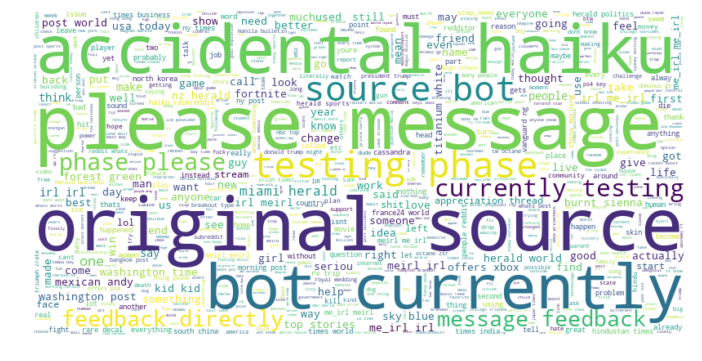

In [33]:
# show
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Sentiment Analysis

- Sentiment analysis refers to the use of natural language processing, text analysis, and computational linguistics to identify emotional states and subjective information.

- Using sentiment analysis, we can gain information about the attitude of the speaker or writer of text with respect to the topic. 

- Today we will just call the [sentiment analysis API](https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis) from TextBlob and take it like a black box as we haven't talked about machine learning yet.

- We want to apply the function to the text column of the dataframe and generate two new columns called polarity and subjectivity. The process will take a long time so we will apply it to a sample of dataset.
    - Polarity refers to the emotions expressed in the text.
    - Subjectivity is a measure of how subjective vs objective the text is.

- Let's use sentiment analysis to analyze the relationship between polarity and number of thumb ups.

In [35]:
# filter out all posts that have less than 100 upvotes
sa_df = df.loc[df.ups > 100]

In [36]:
sample_size = 10000

def sentiment_func(x):
    sentiment = TextBlob(x['selftext'])
    x['polarity'] = sentiment.polarity
    x['subjectivity'] = sentiment.subjectivity
    return x

sample = sa_df.sample(sample_size).apply(sentiment_func, axis=1)

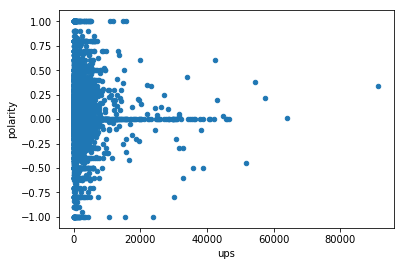

In [37]:
sample.plot.scatter('ups', 'polarity')

# Recommended Resources:

Other advanced libraries in Python that we will cover in the future lectures:

[Spacy](https://spacy.io/)

[Gensim](https://radimrehurek.com/gensim/)